### Paths:

In [201]:
paths = {'eval':'./de-utb/de-eval.tt',
        'test':'./de-utb/de-test.t',
        'train':'./de-utb/de-train.tt'}

### Viterbi Algorithm:

In [202]:
def viterbi_algorithm(states, observations):
    """
    Initialisation step
    """
    viterbi_matrix = [[]]
    backpointer = [[]]
    # for each state s from 1 to N:
    is_empty = True
    for state in states:
        try:
            # viterbi[s,1] = pi_s * b_s(o_1)
            viterbi_matrix[0].append(pi[state] * B[states.index(state)][observations[0]])
            is_empty = False
        except:
            viterbi_matrix[0].append(0)
        # backpointer[s,1] = 0
        backpointer[0].append(0)
    # Handle case where there is no emission data for the word, assume b_s(o_1) = 1
    if is_empty == True:
        for state in states:
            viterbi_matrix[0][states.index(state)] = pi[state]
    """
    Recursive step
    """
    # for each timestep t from 2 to T:
    for t in range(1,len(observations)):
        viterbi_matrix.append([])
        backpointer.append([])
        # for each state s from 1 to N:
        is_empty = True
        for s_current in range(len(states)):
            # viterbi[s,t] = max(viterbi[s',t-1] * a_s',s * b_s(o_t))
            viterbi_scores = []
            for s_previous in range(len(states)):
                try:
                    viterbi_scores.append(viterbi_matrix[t-1][s_previous] * A[s_previous][s_current] * B[s_current][observations[t]])
                    is_empty = False # flags when we have at least one data point for the word
                except:
                    viterbi_scores.append(0)
            viterbi_matrix[t].append(max(viterbi_scores))
            # backpointer[s,t] = argmax(viterbi[s',t-1] * a_s',s * b_s(o_t))
            indices = lambda i: viterbi_scores[i] # indices allows us to find argmax()
            pointer = max(range(len(viterbi_scores)), key=indices)
            backpointer[t].append(pointer)
        # Handle case where there is no emission data for the word (unseen), b_s(o_t) = 1
        if is_empty == True:
            for s_current in range(len(states)):
                viterbi_scores = []
                for s_previous in range(len(states)):
                    viterbi_scores.append(viterbi_matrix[t-1][s_previous] * A[s_previous][s_current])
                viterbi_matrix[t][s_current] = (max(viterbi_scores))
                # backpointer[s,t] = argmax(viterbi[s',t-1] * a_s',s * b_s(o_t))
                indices = lambda i: viterbi_scores[i]
                pointer = max(range(len(viterbi_scores)), key=indices)
                backpointer[t][s_current] = pointer
            
            
    """
    Termination step
    """
    # best_path_probability = max(viterbi[s,T])
    best_path_probability = max(viterbi_matrix[-1])
    # best_path_pointer = argmax(viterbi[s,T])
    indices = lambda i: viterbi_matrix[-1][i]
    best_path_pointer = max(range(len(viterbi_matrix[-1])), key=indices)
    # best_path = starts at best_path_pointer and follows pointers back in time
    best_path = []
    upone = best_path_pointer
    backtrack = backpointer[::-1] # list.reverse() doesn't work on nested lists
    for step in backtrack:
        best_path.append(states[upone])
        upone = step[upone]
    best_path = best_path[::-1]
    return best_path, best_path_probability

### Testing Eisner's Ice Cream

In [203]:
Q = ["H", "C"] # set of states
A = [[0.7, 0.3], [0.4, 0.6]] # transition probability maxtrix P(q_t|q_t-1) ~> A[q_t-1][q_t]
O = ["3", "1", "3"] # sequence of observations : len = T, 
B = [{"1":0.2, "2":0.4, "3":0.4}, {"1":0.5, "2":0.4, "3":0.1}] # emission probabilities : P(o_t|q_t) ~> B[q_t][o_t]
pi = {"H":0.8, "C":0.2} # initial proability distribution : P(pi_1) ~> pi[q_1]

path, prob = viterbi_algorithm(Q, O)
print(f"The best path has a probability of {prob}, and follows nodes {path}")

The best path has a probability of 0.012544000000000003, and follows nodes ['H', 'H', 'H']


### Corpus Reader

This cell is responsible for pre-processing the corpora into various data types (word list, word counts, (un)tagged sentences, etc.), as well as reading in the test corpus and breaking that up into sentences.

In [204]:
from collections import Counter, defaultdict
from nltk.corpus.reader import ConllCorpusReader as CR

training_corpus = CR('./de-utb/', 'de-train.tt', ('words', 'pos',))

words = training_corpus.words()
tagged_words = training_corpus.tagged_words()
tagged_sentences = training_corpus.tagged_sents()
training_sentences = training_corpus.sents()
word_counts = Counter(tagged_words)
raw_training_corpus = training_corpus.raw()
str_training_corpus = raw_training_corpus.split()
raw_counts = Counter(str_training_corpus)

evaluation_corpus = CR('./de-utb/', 'de-test.t', ('words', 'pos',))
evaluation_sentences = evaluation_corpus.sents()

### Calculating initial probabilities table

initial probabilities: probability that sentence starts with tag qjʼ

initial proability distribution : P(pi_1) ~> pi[q_1]

In [205]:
sentence_starters = []
for i in range(len(tagged_sentences)):
    # tagged_sentences[i][0][1] is the part of speech tag for the first word in the ith sentence
    sentence_starters.append(tagged_sentences[i][0][1])
sentence_starter_counts = Counter(sentence_starters)
tags = list(sentence_starter_counts.keys())
cj = {}
for tag in tags:
    # cj = C(#sentences beginning with qj) / #sentences
    cj[tag] = sentence_starter_counts[tag]/len(tagged_sentences)
print("Initial probabilities cj: ", cj)
sum = 0
keys = list(cj.keys())
for key in keys:
    sum += cj[key]
print("sum of cj: ", sum) # If this doesn't come up as ~1, we did something wrong.

Initial probabilities cj:  {'ADV': 0.11772205694857629, 'DET': 0.26151012891344383, 'ADJ': 0.042853095339283186, 'PRON': 0.14300892477688057, 'CONJ': 0.026774330641733957, 'NOUN': 0.14626717665391697, 'NUM': 0.028828445955517777, 'ADP': 0.2122113613826321, 'VERB': 0.014803796571752372, 'PRT': 0.0014874628134296643, '.': 0.003683241252302026, 'X': 0.0008499787505312367}
sum of cj:  1.0


### Calculating transition probabilities table

transition probabilities: probability of tag qj given previous tag qi

transition probability maxtrix P(q_t|q_t-1) ~> A[q_i][q_j]

In [206]:
tag_pair_counts = defaultdict(int)
for sentence in tagged_sentences:
    for i in range(len(sentence)-1): 
        j = i + 1
        # sentence[i][1] is the part of speech tag for the ith word in the sentence
        tag_pair_counts[(sentence[i][1], sentence[j][1])] += 1
        
tag_counts = defaultdict(int)
for tag_pair in tag_pair_counts:
    # Count occurences of qi in contexts q*
    tag_counts[tag_pair[0]] += tag_pair_counts[tag_pair]

# inintialize full array of 0s, in case a tag pair combination remains unseen in training data (like [PRT|.] in our corpus)
aij = [[0] * len(tags) for _ in range(len(tags))] 

for tag_pair in tag_pair_counts:
    tagi = tag_pair[0]
    tagj = tag_pair[1]
    # aij = C(qi, qj) / C(qi, q*)
    aij[tags.index(tagi)][tags.index(tagj)] = tag_pair_counts[tag_pair]/tag_counts[tagi]
print("Sample transition probability aij[0]: ", aij[0])
sum = 0
for prob in aij[0]:
    sum += prob
print("Sum of transition probabilities in aij[0]: ", sum) # If this doesn't come up as ~1, we did something wrong.

Sample transition probability aij[0]:  [0.12207047715393694, 0.10900354071825999, 0.1531782161524195, 0.0336368234699039, 0.015848929354240433, 0.05403810487270275, 0.054291013319844886, 0.20308548305513405, 0.1849603776766144, 0.03566009104704097, 0.03372112628561794, 0.0005058168942842691]
Sum of transition probabilities in aij[0]:  1.0


### Calculating emission probabilities table

emission probabilities: probability of word o given tag qj

emission probabilities : P(o|qj) ~> B[qj][o]

In [207]:
bj = [{} for _ in range(len(tags))] # initialise matrix of empty dictionaries

for word_count in word_counts:
    # bj(o) = C(qj, o) / C(qj)
    bj[tags.index(word_count[1])][word_count[0]] = word_counts[word_count]/raw_counts[word_count[1]]
#print(bj[0])
sum = 0
for word in bj[0]:
    sum += bj[0][word]
print("Sum of probabilities in bj[0]: ", sum)  # If this doesn't come up as ~1, we did something wrong.


Sum of probabilities in bj[0]:  1.0000000000000064


### Setting parameters for running Viterbi on corpus

In [208]:
Q = tags # set of states : len = N
A = aij # transition probability maxtrix P(q_t|q_t-1) ~> A[q_t-1][q_t]
training_O = training_sentences # sequence of untagged training observations : len = T
evaluation_O = evaluation_sentences # sequence of test observations : len = T
B = bj # emission probabilities : P(o_t|q_t) ~> B[q_t][o_t]
pi = cj # initial proability distribution : P(pi_1) ~> pi[q_1]

### Checking trained model against untagged training corpus

Runtime is ~25s

In [209]:
import timeit # will be used for timing each call to the viterbi_algorithm

speed_vs_length = []
with open("training_output.tt", 'w', encoding = 'utf-8') as file:
    for sentence in training_O:
        timer_start = timeit.default_timer()
        path, prob = viterbi_algorithm(Q, sentence) # meat of our program
        timer_stop = timeit.default_timer()
        time = timer_stop - timer_start
        length = len(sentence)
        speed_vs_length.append((length, time))
        zipped_sentence = list(zip(sentence, path))
        for tuple in zipped_sentence:
            file.write(f"{tuple[0]}\t{tuple[1]}\n")
        file.write("\n")

### Running eval.py on training data

    Note: I had to modify the following lines from eval.py in order for the evaluator to handle the German text input. The modified file will be included with my submission.

file_gold = open(sys.argv[1], 'r', ***encoding = 'utf-8'***)

file_system = open(sys.argv[2], 'r', ***encoding = 'utf-8'***)

In [210]:
%run eval_utf8.py "./de-utb/de-train.tt" "./training_output.tt"


Comparing gold file "./de-utb/de-train.tt" and system file "./training_output.tt"

Precision, recall, and F1 score:

  ADV 0.8781 0.9410 0.9084
  ADJ 0.9559 0.9169 0.9360
 NOUN 0.9948 0.9784 0.9866
    . 0.9990 0.9982 0.9986
  DET 0.9655 0.9871 0.9762
 VERB 0.9796 0.9951 0.9873
 PRON 0.9561 0.9119 0.9335
  PRT 0.9009 0.9672 0.9329
  ADP 0.9681 0.9844 0.9762
 CONJ 0.9613 0.9483 0.9547
  NUM 0.9609 0.9786 0.9697
    X 0.6323 0.7072 0.6676

Accuracy: 0.9734



### Evaluation discussion:

Accuracy of predictions running the trained model against untagged training data was 97.34%, which will serve as our baseline for comparison against the untagged evaluation data. We see the lowest precision, recall, and F1 score for X tags, which seems reasonable, since we might expect our model to have a hard time predicting "things that arent really words, and aren't really punctuation". 

### Speed vs Sentence Length for training corpus

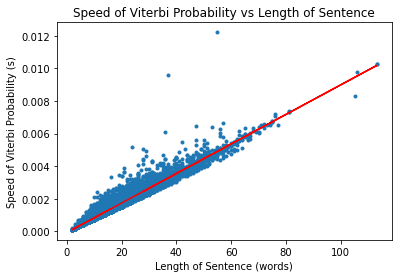

Overall goodness of fit:  0.9478822441823432


In [211]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression as LR
import numpy as np

s_v_l = list(zip(*speed_vs_length))
Y = np.asarray(s_v_l[1])
X = np.asarray(s_v_l[0])
X, Y = X.reshape(-1,1), Y.reshape(-1,1)
plt.plot( X, LR().fit(X, Y).predict(X), color = "red")
plt.scatter(s_v_l[0], s_v_l[1], marker='.')
plt.title("Speed of Viterbi Probability vs Length of Sentence")
plt.xlabel("Length of Sentence (words)")
plt.ylabel("Speed of Viterbi Probability (s)")
plt.show()

model = LR()
fit = model.fit(X, Y)
score = model.score(X, Y)
print("Overall goodness of fit: ", score)

### Regression discussion:

Plot of "Speed of Viterbi Probability vs Length of Sentence" was almost perfectly linear, which was what we were hoping to see, since our hypothesis was that the algorithm will run in O(T*N^2), increasing quadratically with the number of tags, but only linearly with the length of the observations.

Using linear regression to plot the line of best fit, we ended up with an R^2 value between 0.92 and 0.95 in the runs I observed, giving us a pretty strong indication that the function time is in fact linear with respect to the sentence length, with several outliers.

Note: the exact R^2 value and graph vary slightly for each run of the model, suggesting that there is some machine-internal variation for these times, and the exact values will depend somewhat on the each specific instance.

### Plotting the residuals

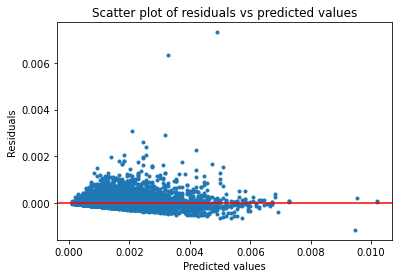

In [212]:
predictions = model.predict(X)
residuals = (Y - predictions)
plt.figure()
plt.scatter(predictions, residuals, marker='.')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.title("Scatter plot of residuals vs predicted values")
plt.axhline(y = np.nanmean(residuals), color = "red")

### Residuals discussion:

Plotting the residuals it becomes obvious that the variance in error increases wtih the predicted values, suggesting that our hypothesis of linear increase in time becomes less accurate as we increase the sentence length. This seems reasonable, since increased sentence length increases the opportunities for our algorithm to deviate from the best-case runtime to worst-case runtime.

### Checking trained model against test corpus

In [213]:
speed_vs_length = []
with open("evaluation_output.tt", 'w', encoding = 'utf-8') as file:
    for sentence in evaluation_O:
        timer_start = timeit.default_timer()
        path, prob = viterbi_algorithm(Q, sentence)
        timer_stop = timeit.default_timer()
        time = timer_stop - timer_start
        length = len(sentence)
        speed_vs_length.append((length,time))
        zipped_sentence = list(zip(sentence, path))
        for tuple in zipped_sentence:
            file.write(f"{tuple[0]}\t{tuple[1]}\n")
        file.write("\n")

### Running eval.py on test data

In [214]:
%run eval_utf8.py "./de-utb/de-eval.tt" "./evaluation_output.tt"


Comparing gold file "./de-utb/de-eval.tt" and system file "./evaluation_output.tt"

Precision, recall, and F1 score:

  DET 0.8232 0.9755 0.8929
 NOUN 0.9294 0.9141 0.9217
 VERB 0.9202 0.9211 0.9206
  ADP 0.9348 0.9775 0.9557
    . 0.9608 0.9996 0.9798
 CONJ 0.9498 0.8974 0.9228
 PRON 0.8671 0.8364 0.8515
  ADV 0.9043 0.8058 0.8523
  ADJ 0.8099 0.7222 0.7635
  NUM 0.9905 0.7704 0.8667
  PRT 0.8712 0.9251 0.8973
    X 0.2222 0.0909 0.1290

Accuracy: 0.9094



### Speed vs Sentence Length for test corpus

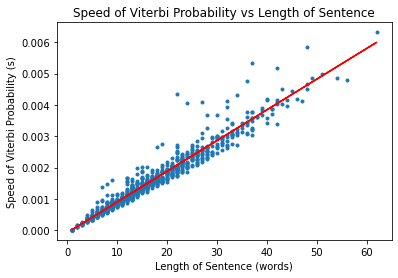

Overall goodness of fit:  0.9443108578320155


In [215]:
s_v_l = list(zip(*speed_vs_length))
Y = np.asarray(s_v_l[1])
X = np.asarray(s_v_l[0])
X, Y = X.reshape(-1,1), Y.reshape(-1,1)
plt.plot( X, LR().fit(X, Y).predict(X), color = "red")
plt.scatter(s_v_l[0], s_v_l[1], marker='.')
plt.title("Speed of Viterbi Probability vs Length of Sentence")
plt.xlabel("Length of Sentence (words)")
plt.ylabel("Speed of Viterbi Probability (s)")
plt.show()

model = LR()
fit = model.fit(X, Y)
score = model.score(X, Y)
print("Overall goodness of fit: ", score)

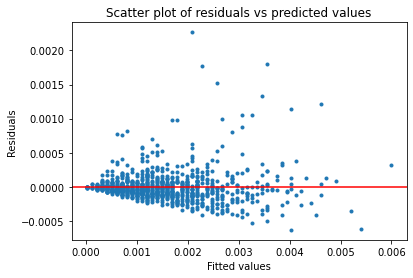

In [216]:
predictions = model.predict(X)
residuals = (Y - predictions)
plt.figure()
plt.scatter(predictions, residuals, marker='.')
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.title("Scatter plot of residuals vs predicted values")
plt.axhline(y = np.nanmean(residuals), color = "red")

### Evaluation discussion:

Accuracy of predictions running the trained model against untagged test data was 90.94%, which I'm pretty happy with. Notice that a significant portion of our error comes again from the X tag, though instead of (X 0.6323 0.7072 0.6676) like in our training data, we end up with (X 0.2222 0.0909 0.1290). I again attribute this to the nature of the X category, and the model's difficulty in handling these non-word/non-punctuation tokens.

The fit of our linear regression over the data in the test corpus has a similar R^2 value to that of the training corpus, varying between 0.90 and 0.97 in the runs I observed, also indicating a linear relationship between run time and sentence length. My hypothesis would have been that, with the test corpus incorporating many tokens that were unseen in training data, the model would have needed extra steps (unseen word handling) required to find the max likelihood at that step in the viterbi matrix, giving us more variance in the runtime. But presuming the unseen data is spread relatively evenenly throughout the test sentences, then the average contribution to the runtime would likely increase proportionally with the amount of unseen data, allowing us to maintain the linear relationship between sentence length and runtime.

Our residuals plot displays similar heteroscedasticity to that of the test corpus. I think it's insightful to note that the outliers in our residuals graph are almost all on the positive side of the mean, suggesting that the variance in runtime is more likely to take much longer than expected (many unknown words), and unlikely to come out significantly shorter than expected (can only go so fast). In both training and test data residual plots, the variance below the mean increases quite regularly, following a linear increase, resulting in a fairly tight cone beneath the mean. These would be our best-case runtimes, when compared with the mean. However the variance above the mean increases much more violently, and while still concentrated around the mean, results in outliers far above our expected value.